# Linear Equation System Solver
### Américo Costa A72121
### Jaime Santos A71739

In [1]:
from qiskit import *
from qiskit.tools.visualization import plot_histogram

from math import pi
import matplotlib.pyplot as plt

## 2x2 Matrix

The following cell will contain all auxiliary functions, coded in the practical lectures, to implement the circuit.

In [2]:
def show_results(D):
    # D is a dictionary with classical bits as keys and count as value
    # example: D = {'000': 497, '001': 527}
    plt.bar(range(len(D)), list(D.values()), align='center')
    plt.xticks(range(len(D)), list(D.keys()))
    plt.show()

# Execute circuit, display a histogram of the results
def execute_locally(qc, draw_circuit=False):
    # Compile and run the Quantum circuit on a simulator backend
    backend_sim = Aer.get_backend('qasm_simulator')
    job_sim = execute(qc, backend_sim, shots=8000)
    result_sim = job_sim.result()
    result_counts = result_sim.get_counts(qc)
    
    # Print the results
    print("simulation: \n\n", result_counts)
    show_results(result_counts)

#Direct Fourier Transform
def qftransform (circuit, qr, swap = True, n=0):
    if n == 0:
        n=qr.size
    for i in range(n-1, -1, -1):
        circuit.barrier()
        circuit.h(qr[i])
        for j in range (i-1, -1, -1):
            r = 2**(i-j+1)
            circuit.cu1((2*pi/r), qr[j], qr[i])
    circuit.barrier()
    if swap == True and n > 1:
        for i in range(0, n//2):
            circuit.swap(qr[i], qr[n-i-1])

#Inverse Fourier Transform
def inverse_qftransform (circuit, qr, swap = True, n=0):
    if n == 0:
        n=qr.size
    if swap == True and n > 1:
        for i in range(0, n//2):
            circuit.swap(qr[i], qr[n-i-1])
    for i in range(0, n, 1):
        circuit.barrier()
        for j in range (0, i, 1):
            r = 2**(i-j+1)
            circuit.cu1((-2*pi/r), qr[i], qr[j])
        circuit.h(qr[i])
    circuit.barrier()
    
#Phase Estimation algorithm using CU3 gates to implement the Hamiltonian operators.
def phase_est(qc, qr,qin, theta, phi, lamb, n):
    teta=-theta
    
    for i in range(n):
        qc.h(qr[i])
        for j in range(2**i):
            qc.cu3(teta,phi,lamb,qr[i],qin[0])
            
    inverse_qftransform(qc,qr,n=n)
    
#Inverse phase estimation for uncomputation
def inv_phase_est(qc,qr,qin,teta,phi,lamb,n):
    qftransform(qc,qr,n=n)
    theta=teta
    for k in range(n):
        for j in range(2**k):
            qc.cu3(theta,phi,lamb,qr[k],qin[0])
        
    for i in range(n):
        qc.h(qr[i])

#Controlled Y rotations using CU3 gate to map the inverse eigenvalues to the registry
def cyr_lamb (qc,qr,qanc,r,n,phi,lamb):
    teta=pi/(2**r)
    u=0
    for k in reversed(range(n)):
            for j in range(2**k):
                qc.cu3(teta,phi,lamb,qr[u],qanc[0])
            u+=1

Attempt to create a function that returns the quantum circuit for solving linear equation systems for a given input.

In [3]:
#Build the HHL algorithm using the auxiliary functions.
def lineq(n,m,k,l,r,A,phi,lamb,kk,t0,T,phi2,lamb2,b):
    qanc = QuantumRegister(m)
    qreg = QuantumRegister(n)
    qin = QuantumRegister(l)
    cb= ClassicalRegister(k)
    qc= QuantumCircuit(qanc,qreg,qin,cb)
    theta= A[0][1] * kk * t0 / T

    if(b=='1'):
        qc.x(qin) #e preciso por o x no fim?
    if(b=='h'):
        qc.h(qin)
    phase_est(qc,qreg, qin,theta,phi,lamb,n)
        
    #R(lamb)
    cyr_lamb(qc,qreg,qanc,r,n,phi2,lamb2)
    #R(lamb)
        
    inv_phase_est(qc,qreg, qin,theta,phi,lamb,n)
    qc.barrier()
    qc.measure(qanc[0],cb[0])
    qc.measure(qin[0],cb[1])
    qc.barrier()
    return qc

Different inputs to create a more generalized 2x2 circuit

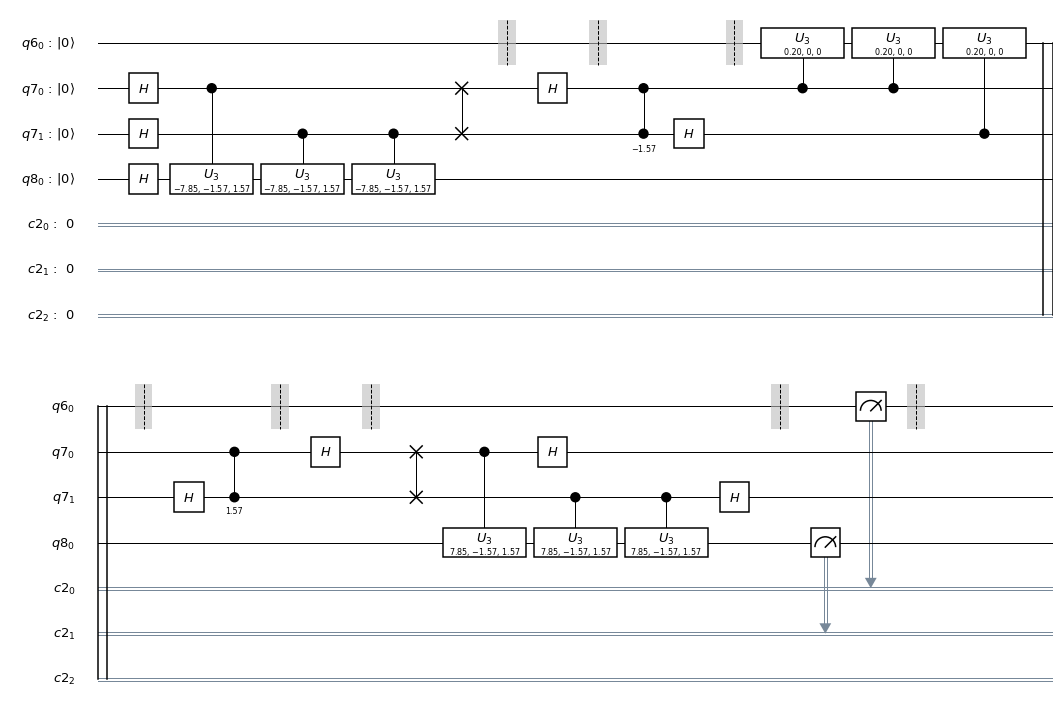

In [18]:
#Matrices
A=[[1.5,1],[1,1.5]] ## kk=5 
#A=[[2,-1],[-1,2]] ## kk=3
#Matrices

b = 'h' # states for b, |0> , |1> or |0> + |1>, '0' for state 0, '1', or 'h'
n=2 # registers
m=1 # acillas
k=3 # classical bits
l=1 # input qbits
r=4 # fidelity

phi= -pi/2   #phase estimation angle phi set in RX
lamb = pi/2 #phase est+imation angle lambda set in RX

kk = 5   #hamiltonian evolution number k lambdamax/lambdamin
t0 = 2*pi   #hamiltonian evolution number t0
T = 2**n    #hamiltonian evolution number T

phi2 = 0 #inverse eigenvalue rotation set in RY
lamb2 = 0 #inverse eigenvalue rotation set in RY


circ = lineq(n,m,k,l,r,A,phi,lamb,kk,t0,T,phi2,lamb2,b)
circ.draw(output='mpl')


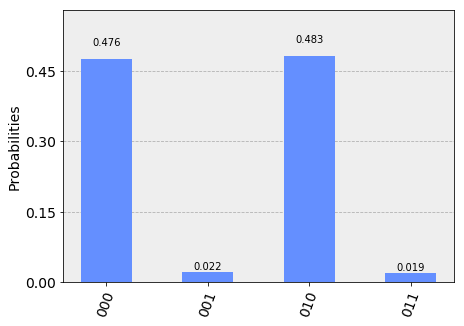

In [25]:
#circuit building
backend = Aer.get_backend('qasm_simulator')

job_sim = execute(circ, backend=backend, shots=8192,)
#result = job.result()
result_sim = job_sim.result()
result_counts = result_sim.get_counts(circ)
plot_histogram(result_counts)

simulation: 

 {'010': 7742, '011': 193, '000': 4, '001': 61}


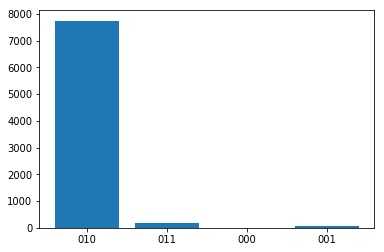

In [11]:
#Measurements of the circuit shots = 8k
execute_locally(circ)

# 4x4 Matrix

In the following cell, we define the phase estimation and its inverse with the hamiltonian evolution operator as the decomposition present in the article.

In [26]:
def phase_est2(qc, qr,qin, n):#theta, phi, lamb, n):
    #teta=
    qc.h(qr[0])
    qc.h(qr[1])
    qc.h(qr[2])
    qc.h(qr[3])
    ##decomposition of A
    for i in range(n):        
        for j in range(2**i):
            #CCZ
            qc.barrier()
            qc.ch(qr[i],qin[1])
            qc.ccx(qr[i],qin[0],qin[1])
            qc.ch(qr[i],qin[1])
            
            ##CRX
            qc.barrier()
            qc.cu3(-0.2,-pi/2,pi/2,qr[i],qin[1])
            
            #CV
            qc.barrier()
            qc.ch(qr[i],qin[1])
            qc.cu1(pi/2,qr[i],qin[1])
            qc.ch(qr[i],qin[1])
            
            ##CRZZ
            qc.barrier()
            qc.ccx(qr[i],qin[0],qin[1])
            qc.cu1(-0.38,qr[i],qin[1])
            qc.ccx(qr[i],qin[0],qin[1])
            
            ##CRX
            qc.barrier()
            qc.cu3(-0.98,-pi/2,pi/2,qr[i],qin[0])
            
            #CRZZ
            qc.barrier()
            qc.ccx(qr[i],qin[1],qin[0])
            qc.cu1(-1.88,qr[i],qin[0])
            qc.ccx(qr[i],qin[1],qin[0])
            
            #CCX
            qc.barrier()
            qc.ccx(qr[i],qin[0],qin[1])
            
            ##CRX
            qc.barrier()
            qc.cu3(-0.59,-pi/2,pi/2,qr[i],qin[0]) 
            
            #CCX
            qc.barrier()
            qc.ccx(qr[i],qin[0],qin[1])
            
            #cz
            qc.barrier()
            qc.cz(qr[i],qin[1])
            
            
    inverse_qftransform(qc,qr,n=n)

def inv_phase_est2(qc,qr,qin,n):
    qftransform(qc,qr,n=n)
    #decomposition of A
    for i in range(n):
        for j in range(2**i):
            #CCZ
            qc.barrier()
            qc.ch(qr[i],qin[1])
            qc.ccx(qr[i],qin[0],qin[1])
            qc.ch(qr[i],qin[1])
            
            ##CRX
            qc.barrier()
            qc.cu3(0.2,-pi/2,pi/2,qr[i],qin[1])
            
            #CV
            qc.barrier()
            qc.ch(qr[i],qin[1])
            qc.cu1(-pi/2,qr[i],qin[1])
            qc.ch(qr[i],qin[1])
            
            ##CRZZ
            qc.barrier()
            qc.ccx(qr[i],qin[0],qin[1])
            qc.cu1(0.38,qr[i],qin[1])
            qc.ccx(qr[i],qin[0],qin[1])
            
            ##CRX
            qc.barrier()
            qc.cu3(0.98,-pi/2,pi/2,qr[i],qin[0])
            
            #CRZZ
            qc.barrier()
            qc.ccx(qr[i],qin[1],qin[0])
            qc.cu1(1.88,qr[i],qin[0])
            qc.ccx(qr[i],qin[1],qin[0])
            
            #CCX
            qc.barrier()
            qc.ccx(qr[i],qin[0],qin[1])
            
            ##CRX
            qc.barrier()
            qc.cu3(0.59,-pi/2,pi/2,qr[i],qin[0]) 
            
            #CCX
            qc.barrier()
            qc.ccx(qr[i],qin[0],qin[1])
            
            #cz
            qc.barrier()
            qc.cz(qr[i],qin[1])
            
        
    for i in range(n):
        qc.h(qr[i])

def cyr_lamb2 (qc,qr,qanc,r,n,phi,lamb):
    teta= pi/64
    u=0
    for k in reversed(range(n)):
            for j in range(2**k):
                qc.cu3(teta,phi,lamb,qr[u],qanc[0])
            u+=1
    
        

Function Lineq that will assemble all the parts according to the HHL algorith.

In [30]:
def lineq4(qc,qreg,qin,cb,n,m,k,l,b):
    if b=='h':
        qc.barrier()
        qc.h(qin)
        qc.barrier()
    if b=='1':
        qc.barrier()
        qc.x(qin)
        qc.barrier()

    ##circuit building###
    phase_est2(qc,qreg,qin,n)
    qc.barrier()
    qc.swap(qreg[1],qreg[3])
    cyr_lamb(qc,qreg,qanc,0,4,5*pi,3*pi)
    inv_phase_est2(qc,qreg,qin,n)
    ##circuit building###

    qc.barrier()
    qc.measure(qanc[0],cb[0])
    qc.measure(qin[0],cb[1])
    qc.measure(qin[1],cb[2])



Creation of the 4x4 circuit. Since it has many gates, it will be very slow to draw.

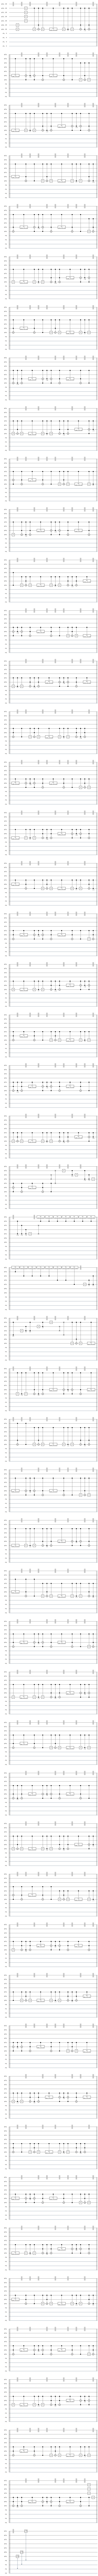

In [31]:
n=4 # registers
m=1 # acillas
k=4 # classical bits
l=2 # input qbits
b='h'

qanc = QuantumRegister(m)
qreg = QuantumRegister(n)
qin = QuantumRegister(l)
cb= ClassicalRegister(k)
qc= QuantumCircuit(qanc,qreg,qin,cb)

lineq4(qc,qreg,qin,cb,n,m,k,l,b)
qc.draw(output='mpl')

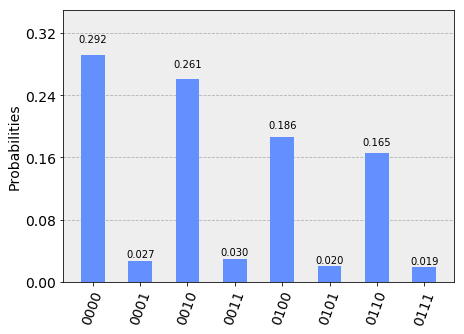

In [37]:
job_sim = execute(qc, backend=backend, shots=8192,)
#result = job.result()
result_sim = job_sim.result()
result_counts = result_sim.get_counts(qc)
plot_histogram(result_counts)

In [ ]:
execute_locally(qc)